In [1]:
import argparse
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import os


def find_elbow_point_k(X, max_k=10):
    "INPUT  :  X matrix with data , number of clusters "
    "OUTPUT : the elbow point (=optimal number of clusters) after K-means algorithm "

    wss = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        wss.append(kmeans.inertia_)

    # Calculate the difference between successive WSS values
    wss_diff = np.diff(wss)

    # Calculate the second difference
    wss_diff2 = np.diff(wss_diff)

    # Find the index corresponding to the knee point on the second difference curve
    knee = np.argmax(wss_diff2) + 2
    return knee


def save_clusters_to_csv(filenames, cluster_labels, optimal_k):
    "    INPUT: "
    "    filenames : the list of names of the initial dataset data "
    "    cluster_labels : generated after the k_means algorithm  "
    "    optima_k : generated after the k_means algorithm (with elbow method) "
    "    OUTPUT: files cluster_{i}.csv containing the list of files in each cluster, one per each final cluster"

    # Create a directory for saving the clusters
    os.makedirs(f"cluster_dir_{optimal_k}", exist_ok=True)
    # Save each cluster to a separate CSV file
    for i in range(optimal_k):
        cluster_indices = (cluster_labels == i)
        cluster_filenames = filenames[cluster_indices]
        cluster_data = pd.DataFrame({"filename": cluster_filenames})
        cluster_data.to_csv(f"~/Desktop/photos_valentina/cluster_dir_{optimal_k}/cluster_{i}.csv", index=False)


def generate_summary_file(clustered_data, cluster_labels, filename="summary.txt"):  
    # Get the number of files in each cluster
    cluster_counts = clustered_data.groupby("cluster_label").size().reset_index(name="count")
    #print(cluster_counts)
    
    # Calculate useful statistics about the files in each cluster
    cluster_stats = clustered_data.groupby("cluster_label").describe()
    #print(cluster_stats)
    
    # Write the summary to a file
    with open(filename, "w") as f:
        for i in range(len(cluster_counts)):
            cluster_num = cluster_counts.loc[i, "cluster_label"]
            count = cluster_counts.loc[i, "count"]
            stats = cluster_stats.loc[cluster_num]

            f.write(f"Cluster {cluster_num}\n")
            f.write(f"Number of files: {count}\n")
            f.write(f"Statistics:\n{stats}\n\n")

Optimal number of clusters:  2
Silhouette score:  0.7062354583695932


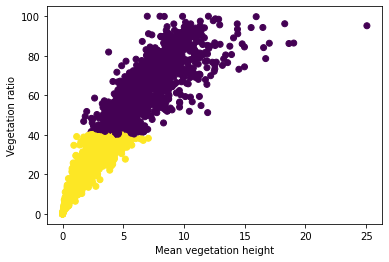

Here!!!!
      mean_veg_height  median_veg_height  vegetation_ratio (%)  \
0            1.802241           0.000000             20.553456   
1            8.776256           9.287244             89.889996   
2            2.883744           0.000000             27.986370   
3            0.704116           0.000000             10.065354   
4            0.780876           0.000000             10.443301   
...               ...                ...                   ...   
4444         6.072342           4.575888             62.232663   
4445         0.338850           0.000000              7.077040   
4446         0.775022           0.000000             10.782876   
4447         1.611381           0.000000             17.237083   
4448         4.250081           0.000000             45.832879   

      building_ratio (%)  veg_variance  cluster_label  
0              79.446544     23.295397              1  
1              10.110004     10.616480              0  
2              72.013630     2

In [2]:
## 0. Set up command line argument parsing
parser = argparse.ArgumentParser(description="Perform clustering analysis on input data")
#parser.add_argument("input_path", help="Path to the input CSV file")
#parser.add_argument("output_dir", help="Path to the output directory")
#args = parser.parse_args()

# 1. RLoad data from CSV file as a DataFrame and remove unnecessary columns
data = pd.read_csv("~/Desktop/BuildingHeights_Phase2/vegetation_analysis/output.csv")
filenames = data["filename"]
data = data.drop(["filename", "veg_quantiles"], axis=1)

# 2. Normalize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 3. Select the features
selected_features = ["mean_veg_height", "vegetation_ratio (%)"]
selected_data = data[selected_features]

# 4. Cluster analysis
kmeans = KMeans(n_clusters=2)
kmeans.fit(selected_data)
cluster_labels = kmeans.predict(selected_data)

# 5. Cluster evaluation
# Use the function find_elbow_point_k from the other library
optimal_k = find_elbow_point_k(selected_data, max_k=10)
print("Optimal number of clusters: ", optimal_k)

# 6. Run KMeans clustering with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(selected_data)
cluster_labels = kmeans.predict(selected_data)

# 7. Use the silhouette score to evaluate the quality of the clustering
silhouette_score_val = silhouette_score(selected_data, cluster_labels)
print("Silhouette score: ", silhouette_score_val)

## 8. Save clusters to CSV files
#save_clusters_to_csv(filenames, cluster_labels, optimal_k)

# 9. Visualization
plt.scatter(selected_data["mean_veg_height"], selected_data["vegetation_ratio (%)"], c=cluster_labels)
plt.xlabel("Mean vegetation height")
plt.ylabel("Vegetation ratio")
plt.show()

# 10. Interpretation
clustered_data = data.copy()
print('Here!!!!')
clustered_data["cluster_label"] = cluster_labels
clustered_data.groupby("cluster_label").mean()
print(clustered_data)

# 11. Generate the summary file summary.txt containing the statistics on each cluster
generate_summary_file(clustered_data, cluster_labels)

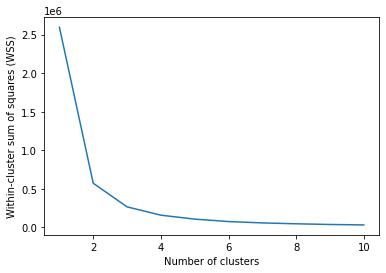

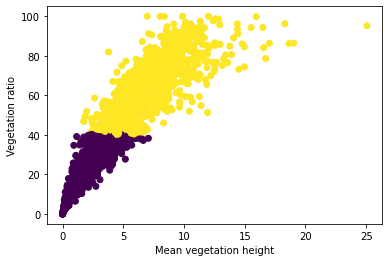

In [4]:
# We rerun the cluster analysis using another method 

# 4. Cluster analysis
kmeans = KMeans(n_clusters=2)
kmeans.fit(selected_data)
cluster_labels = kmeans.predict(selected_data)

# 5. Cluster evaluation
# Use the elbow method to determine the optimal number of clusters
wss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(selected_data)
    wss.append(kmeans.inertia_)
plt.plot(range(1, 11), wss)
plt.xlabel("Number of clusters")
plt.ylabel("Within-cluster sum of squares (WSS)")
plt.show()

# 9. Visualization
plt.scatter(selected_data["mean_veg_height"], selected_data["vegetation_ratio (%)"], c=cluster_labels)
plt.xlabel("Mean vegetation height")
plt.ylabel("Vegetation ratio")
plt.show()

In [6]:
# Double check the optimal number of cluster by looking at silhoutte scores 
min_k = 2
max_k = 6

# Evaluate the silhouette score for each k value
best_score = -1
best_k = -1
for k in range(min_k, max_k+1):
    # Run k-means clustering
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(selected_data)
    # Evaluate the silhouette score
    silhouette_score_val = silhouette_score(selected_data, cluster_labels)
    print(f"k={k}, silhouette score: {silhouette_score_val:.3f}")
    # Keep track of the best k value
    if silhouette_score_val > best_score:
        best_score = silhouette_score_val
        best_k = k

print(f"Best k value: {best_k}, silhouette score: {best_score:.3f}")

k=2, silhouette score: 0.694
k=3, silhouette score: 0.657
k=4, silhouette score: 0.600
k=5, silhouette score: 0.558
k=6, silhouette score: 0.550
Best k value: 2, silhouette score: 0.694
